# Starter Notebook and some approach

The goal of this notebook is to provide a brief introduction to the challenge and the data associated with it. It won't go into detail on a solution approach since this is a challenge which may be approached in a number of ways.

In [33]:
import pandas as pd
import geopandas as gpd # For loading the map of road segments

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

# The Challenge

The main dataset for this challenge (in Train.csv) is a record of crashes within Nairobi over 2018-19. Each crash has an associated datetime and location. Let's load the data and take a look.

In [35]:
# Load the data
df = pd.read_csv('Data/Train.csv', parse_dates=['datetime'])
print(df.shape)
df.head()

(6318, 4)


,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382


<AxesSubplot:title={'center':'Crash Locations'}, xlabel='longitude', ylabel='latitude'>

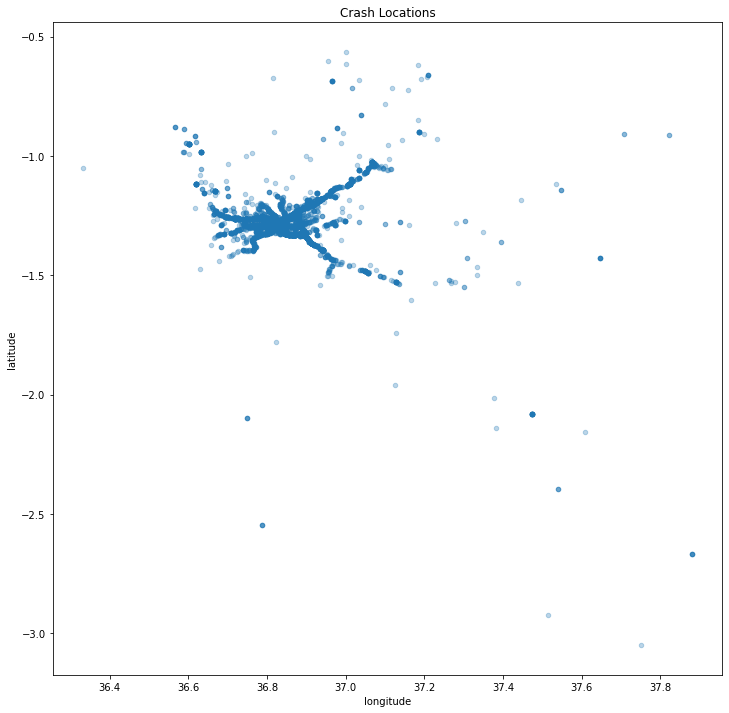

In [36]:
# Plot the crashes

df.plot(x='longitude', y='latitude', kind='scatter', figsize=(12, 12), alpha=0.3, title='Crash Locations')

In [37]:
df['Date'] = pd.to_datetime(df['datetime'])

Rather than trying to predict accident locations or the number of accidents in a given timeframe, we are instead asked to come up with an ambulance deployment schedule that will minimise distance travelled. 

This is of course a simplification of the problem, but by solving this you will hopefully develop strategies that can be used going forward.

In [249]:
# View the submission format
ss = pd.read_csv('Data/SampleSubmission.csv', parse_dates=['date'])
ss.head()

,date,A0_Latitude,A0_Longitude,A1_Latitude,A1_Longitude,A2_Latitude,A2_Longitude,A3_Latitude,A3_Longitude,A4_Latitude,A4_Longitude,A5_Latitude,A5_Longitude
0,2019-07-01 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-07-01 03:00:00,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-07-01 06:00:00,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-07-01 09:00:00,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-07-01 12:00:00,0,0,0,0,0,0,0,0,0,0,0,0


# Scoring

You can re-create the scoring process by creating your own test set and using the following function:

In [39]:
def score(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon in ref[['datetime', 'latitude', 'longitude']].values:
        row = sub.loc[sub.date < date].tail(1) # Prior to Oct 2 this was incorrectly .head(1)
        dists = []
        for a in range(6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
        total_distance += min(dists)
    return total_distance

In [248]:
# Example:

# Test set
reference = df.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')

# Create submission dataframe
sub = pd.DataFrame({
    'date':dates
})
for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = 0
    sub['A'+str(ambulance)+'_Longitude'] = 0

# Place an ambulance in the center of the city:
sub['A'+str(ambulance)+'_Latitude'] = 36.82
sub['A'+str(ambulance)+'_Longitude'] = -1.3



score(sub, reference)

70886.38526378157

This scoring function can be used for local testing without needing to submit on Zindi. Lower is better. Experiment with specifying set locations for all 6 ambulances, and see how low you can get your score.

# Weather Data

Some weatehr variables form the GFS dataset are provided, covering the greater Nairobi area. Let's take a quick look at the dataset before moving on:

In [41]:
weather = pd.read_csv('Data/Weather_Nairobi_Daily_GFS.csv', parse_dates=['Date'])
weather['Date'] = pd.to_datetime(weather['Date'].dt.date)
weather.head()

,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground
0,2018-01-01,24.100000,72.700005,0.009560,15.161493,-0.012186,-0.933914
1,2018-01-02,27.362288,74.900002,0.010463,16.047998,0.314543,-0.485459
2,2018-01-03,30.246618,86.599998,0.011930,15.838525,-0.282732,-0.653965
3,2018-01-04,33.010689,90.900002,0.012780,16.169244,0.211572,0.908123
4,2018-01-05,27.250372,82.413353,0.011392,15.923456,1.047275,-0.037742


# Road Survey Data

The road survey data contains many different measurements for each surveyed road segment. Unfortunately we can't access the raw data, and must work 'in the dark' in terms of what the column headings mean. However, the naming convention does at least show which columns may be related.

To locate the road segments geographically, a geojson file is provided. Here is an example of merging the survey data with the segments and visualizing the result.

In [42]:
# Load the survey data
road_surveys = pd.read_csv('Data/Segment_info.csv')
road_surveys.head()

,segment_id,side,25_48,79_76,79_65,79_39,28_78_50,55_90,26_76,92_30,...,80_97_61_65_11,80_97_61_65_12,80_97_61_65_15,80_97_61_65_16,80_97_61_39_0,80_97_61_39_10,80_97_61_39_11,80_97_61_39_12,80_97_61_39_15,80_97_61_39_16
0,176_2,1,3,0,3,3,0.0,11,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,176_2,2,3,0,3,3,0.0,11,0,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,95_1,1,3,0,3,3,0.0,14,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,95_1,2,3,0,3,3,0.0,14,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,144_7,1,1,0,4,3,0.0,5,0,3,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [158]:
# Load the map
road_segment_locs = gpd.read_file('Data/segments_geometry.geojson')
road_segment_locs.head()

,segment_id,road_name,geometry
0,28_1,accra road-tertiary,"LINESTRING (36.82603 -1.28447, 36.82605 -1.284..."
1,137_1,accra road-tertiary,"LINESTRING (36.82656 -1.28371, 36.82658 -1.283..."
2,137_2,accra road-tertiary,"LINESTRING (36.82711 -1.28289, 36.82713 -1.282..."
3,1_1,airport north road-primary,"LINESTRING (36.88646 -1.33284, 36.88649 -1.332..."
4,1_2,airport north road-primary,"LINESTRING (36.88726 -1.33226, 36.88729 -1.332..."


<AxesSubplot:>

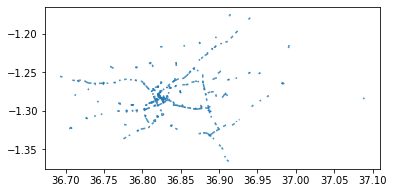

In [159]:
# Because this is a geodataframe, we can plot it
road_segment_locs.plot()

<AxesSubplot:>

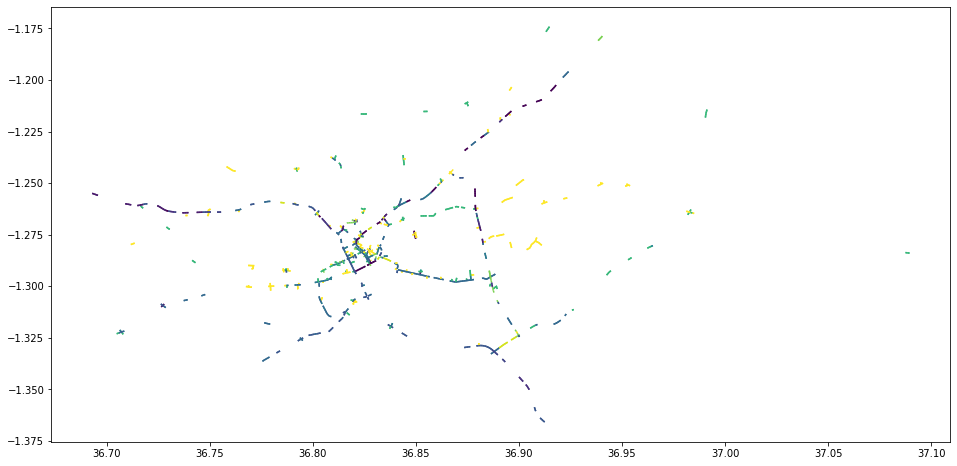

In [160]:
# Let's merge the two and color by one of the survey columns
segments_merged = pd.merge(road_segment_locs, road_surveys, on='segment_id', how='left')
segments_merged.plot(column='55_90', figsize=(20, 8))

<AxesSubplot:>

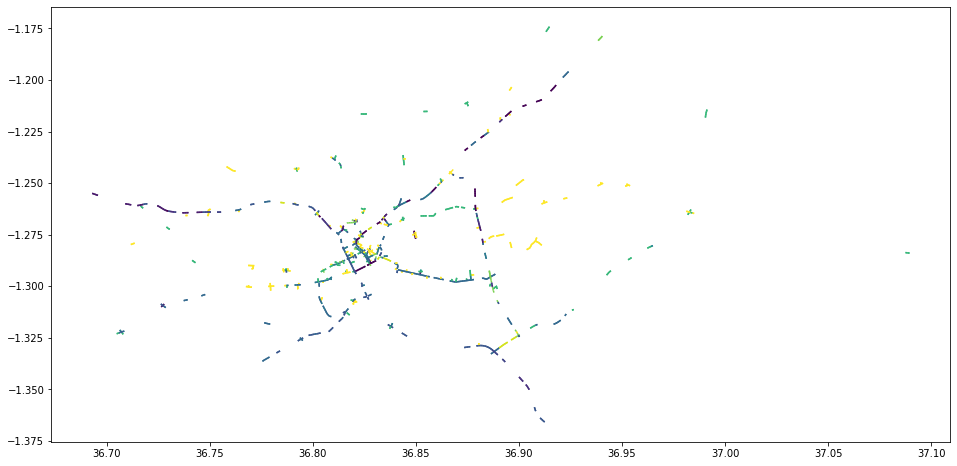

In [161]:
segments_merged.plot(column='55_90', figsize=(20, 8))

Let's see if segment geometry is comparable with the scale of our task. 

In [165]:
from shapely.geometry import LineString, shape
import numpy as np

segments_merged['geometry'] = segments_merged['geometry'].apply(lambda x: np.array(list(shape(x).coords)))
segments_merged['geometry'].apply(lambda x: np.std(x[:, 0])).max()

0.0005350749622266016

We can see that the length of the biggest road segment is almost 1000 times smaller than the scale of the roadmap. So it's reasonable to store just a mean instead of all the dots in segment geometry. 

In [167]:
segments_merged['geometry'] = segments_merged['geometry'].apply(lambda x: np.mean(x[:, 0]))

In [171]:
segments_merged['geometry'].describe()

count    1535.000000
mean       36.839393
std         0.055332
min        36.693519
25%        36.811192
50%        36.831721
75%        36.880048
max        37.088976
Name: geometry, dtype: float64

In [ ]:
from scipy.spatial.distance import euclidean as edist
from tqdm.notebook import tqdm

df['segment_id'] = df[['longitude', 'latitude']].apply(lambda x: (x[0], x[1]), axis=1)
for i in tqdm(range(df.shape[0])):
    crash_coords = df.iloc[i]['segment_id']
    min_dist = 100
    segment_id = 0
    for j in range(road_segment_locs.shape[0]):
        dots = np.array(list(shape(road_segment_locs.iloc[j]['geometry']).coords))
        distances = [edist(crash_coords, x) for x in dots]
        if min(distances) < min_dist:
            min_dist = min(distances)
            segment_id = road_segment_locs.iloc[j]['segment_id']
    df.loc[df.uid == i+1, 'segment_id'] = segment_id

In [200]:
df.loc[df.uid == 1, 'segment_id'] = road_segment_locs.iloc[0]['segment_id']

In [201]:
df.head()

,uid,datetime,latitude,longitude,time_passed,Date,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,segment_id
0,1,2018-01-01 00:25:46,-1.188850,36.931382,0.000000,2018-01-01,24.1,72.700005,0.00956,15.161493,-0.012186,-0.933914,28_1
1,2,2018-01-01 02:02:39,-0.662939,37.208730,76.243032,2018-01-01,24.1,72.700005,0.00956,15.161493,-0.012186,-0.933914,"(37.208730003992294, -0.662938762534417)"
2,3,2018-01-01 02:31:49,-0.662939,37.208730,41.833001,2018-01-01,24.1,72.700005,0.00956,15.161493,-0.012186,-0.933914,"(37.208730003992294, -0.662938762534417)"
3,4,2018-01-01 03:04:01,-1.288087,36.826583,43.954522,2018-01-01,24.1,72.700005,0.00956,15.161493,-0.012186,-0.933914,"(36.826583403307296, -1.28808711064054)"
4,5,2018-01-01 03:58:49,-1.188850,36.931382,57.341085,2018-01-01,24.1,72.700005,0.00956,15.161493,-0.012186,-0.933914,"(36.931382436751214, -1.18884981099406)"


In [ ]:
df.to_csv('preprocessed_df.csv', index=False)

# PCA and TNSE on road survey data

In [207]:
#fill NaN's with mean over the column
for name, column in road_surveys.iteritems():
    road_surveys[name] = road_surveys[name].fillna(column.mean())

In [208]:
road_surveys.head()

,segment_id,side,25_48,79_76,79_65,79_39,28_78_50,55_90,26_76,92_30,...,80_97_61_65_11,80_97_61_65_12,80_97_61_65_15,80_97_61_65_16,80_97_61_39_0,80_97_61_39_10,80_97_61_39_11,80_97_61_39_12,80_97_61_39_15,80_97_61_39_16
0,176_2,1,3,0,3,3,0.0,11,0,1,...,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
1,176_2,2,3,0,3,3,0.0,11,0,1,...,0.000000,1.00000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2,95_1,1,3,0,3,3,0.0,14,0,3,...,0.225703,0.59759,0.079518,0.04498,0.171266,0.064123,0.225649,0.599838,0.078734,0.043831
3,95_1,2,3,0,3,3,0.0,14,0,3,...,0.225703,0.59759,0.079518,0.04498,0.171266,0.064123,0.225649,0.599838,0.078734,0.043831
4,144_7,1,1,0,4,3,0.0,5,0,3,...,0.000000,1.00000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000


In [209]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=33)
road_surveys_tsne = tsne.fit_transform(road_surveys.loc[:, road_surveys.columns != 'segment_id'])

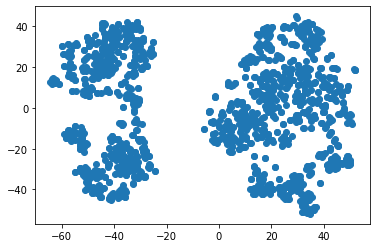

In [210]:
plt.scatter(road_surveys_tsne[:, 0], road_surveys_tsne[:, 1]);

In [212]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
coordinates_pca = pca.fit_transform(road_surveys.loc[:, road_surveys.columns != 'segment_id'])

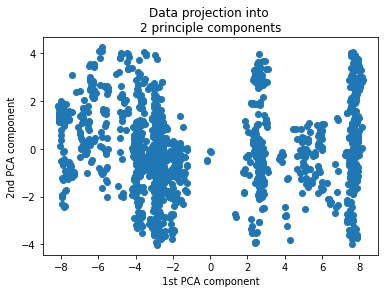

In [214]:
plt.scatter(coordinates_pca[:, 0], coordinates_pca[:, 1])
plt.xlabel('1st PCA component')
plt.ylabel('2nd PCA component')
plt.title('Data projection into \n2 principle components');

In [224]:
pca = PCA(n_components=5)
coordinates_pca = pca.fit_transform(road_surveys.loc[:, road_surveys.columns != 'segment_id'])
coordinates_pca = pd.DataFrame(data=coordinates_pca)

In [218]:
explained_ratio = pca.explained_variance_ratio_
print(explained_ratio)

[0.48266732 0.05795862 0.04297979 0.03664731 0.02505325 0.01770572
 0.01671424 0.01472844 0.01257608 0.01147894 0.01050136 0.00901318
 0.00827583 0.00803383 0.00702809 0.00665264 0.00617605 0.00604883
 0.00556744 0.00540363]


In [225]:
road_surveys_pca =  pd.concat([road_surveys['segment_id'], coordinates_pca], axis=1)

In [226]:
road_surveys_pca.head()

,segment_id,0,1,2,3,4
0,176_2,2.666511,3.430179,-0.316824,-0.878743,-1.576142
1,176_2,2.588418,3.488764,-0.935944,-1.514185,-1.307881
2,95_1,5.268822,0.268885,-0.812285,-1.885284,0.571214
3,95_1,5.232784,0.430002,-1.131024,-1.695353,0.073250
4,144_7,-3.585398,-0.885988,0.779510,-1.841260,2.080199


# Vector AutoRegression

In [47]:
# start with a little preprocessing of our data
df = df.drop('Date', axis=1)
df['time_passed'] = df['datetime'].diff().dt.total_seconds()

In [48]:
print(df['time_passed'].min(), df['time_passed'].max()) 

0.0 314430.0


In [49]:
import numpy as np

# we will use sqrt(t) instead a difference itself
# because there are some huge values and it may cause gradient decsent diverge
df['time_passed'] = df['time_passed'].apply(lambda x: np.sqrt(x))
df = df.fillna(0)

In [110]:
df['Date'] = pd.to_datetime(df['datetime'].apply(lambda x: x.date()))
X = pd.merge(df[['uid', 'time_passed', 'latitude', 'longitude', 'Date']],weather, on = 'Date')

In [111]:
X = X.drop('Date', axis=1)

In [116]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")   

In [117]:
for name, column in df[['time_passed', 'longitude', 'latitude']].iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "time_passed" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.8788
 No. Lags Chosen       = 11
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "longitude" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -24.936
 No. Lags Chosen       = 5
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "latitude" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significanc

Seems like all the interesting data about crashes are stationary. This is important to perform vector auto-regression.

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In [143]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=14
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(X_train, variables = X_train.columns) 

/home/adalnhard/.local/lib/python3.6/site-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 2, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


,time_passed_x,longitude_x,latitude_x
time_passed_y,1.0000,0.0806,0.3677
longitude_y,0.1140,1.0000,0.0008
latitude_y,0.3389,0.0012,1.0000


In [121]:
from tqdm.notebook import tqdm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

X_train = df.iloc[:6000][['time_passed', 'longitude', 'latitude']]
X_test = df.iloc[6000:][['time_passed', 'longitude', 'latitude']]

model = VAR(X_train)
for i in tqdm(range(2, 20)):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 2
AIC :  -0.6993337719962157
HQIC:  -0.6911884544181421 

Lag Order = 3
AIC :  -0.726100465938355
HQIC:  -0.7144625494046764 

Lag Order = 4
AIC :  -0.7278324183389523
HQIC:  -0.7127008529988111 

Lag Order = 5
AIC :  -0.7290244706183189
HQIC:  -0.7103982061276163 

Lag Order = 6
AIC :  -0.7372493990101686
HQIC:  -0.7151273845312502 

Lag Order = 7
AIC :  -0.7390244575241797
HQIC:  -0.7134056417255211 

Lag Order = 8
AIC :  -0.737839192635575
HQIC:  -0.7087225236914677 

Lag Order = 9
AIC :  -0.7365321077923964
HQIC:  -0.7039165333826332 

Lag Order = 10
AIC :  -0.739422211083903
HQIC:  -0.7033066783934626 

Lag Order = 11
AIC :  -0.7368157866848226
HQIC:  -0.6971992424035545 

Lag Order = 12
AIC :  -0.7355273608628831
HQIC:  -0.6924087511851921 

Lag Order = 13
AIC :  -0.7358865539416257
HQIC:  -0.6892648245661568 

Lag Order = 14
AIC :  -0.7356594081742004
HQIC:  -0.6855335043035217 

Lag Order = 15
AIC :  -0.7334895361330207
HQIC:  -0.6798584024733082 

Lag Order = 16
AI

AIC drops to lowest at lag 13, then increases. Let's go with the lag 13.

In [123]:
model_fitted = model.fit(13)
lag_order = model_fitted.k_ar
forecast_input = X_train.values[-lag_order:]

fc = model_fitted.forecast(y=forecast_input, steps=X_test.shape[0])

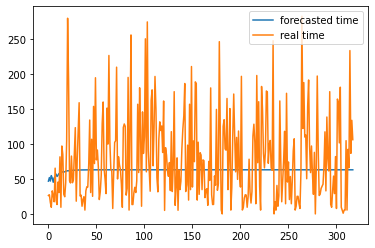

In [173]:
plt.plot(fc[:, 0], label='forecasted time')
plt.plot(X_test['time_passed'].to_numpy(), label='real time')
plt.legend()
plt.show()

It looks like autoregression converges to some constant value. The same is for longitude and latitude features. 

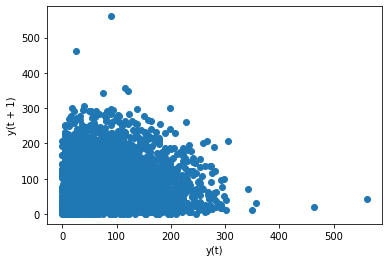

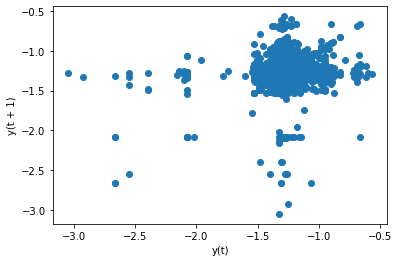

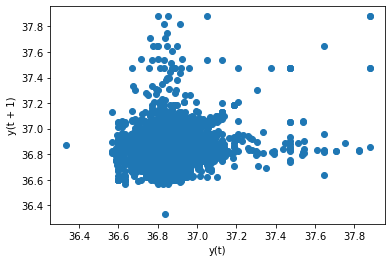

In [87]:
from pandas.plotting import lag_plot

lag_plot(df['time_passed'])
plt.show()
lag_plot(df['latitude'])
plt.show()
lag_plot(df['longitude'])
plt.show()

Just some blobs of dots, no clear time-dependancy is observed. So it's better to stop trying to predict future crashes treating our data as a time series.

# Predicting the probability of a crash on each of the road segments

In [230]:
segment_ids = road_surveys['segment_id'].unique()

In [261]:
dates = pd.to_datetime(ss['date'].apply(lambda x: x.date()))
dates = dates.unique()

In [326]:
preprocessed_df = pd.read_csv('Data/preprocessed_df.csv', parse_dates=['datetime'])

In [328]:
preprocessed_df['Date'] = pd.to_datetime(preprocessed_df['datetime'].apply(lambda x: x.date()))
df_with_weather = pd.merge(preprocessed_df, weather, on = 'Date')

In [332]:
df_with_weather = pd.merge(df_with_weather, road_surveys_pca, on='segment_id')
df_with_weather = df_with_weather.drop(['latitude', 'longitude'], axis=1)
df_with_weather = df_with_weather.drop(['datetime'], axis=1)

In [333]:
df_with_weather.head()

,uid,Date,segment_id,precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,specific_humidity_2m_above_ground,temperature_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,0,1,2,3,4
0,1,2018-01-01,58_1,24.100000,72.700005,0.009560,15.161493,-0.012186,-0.933914,-2.398031,-3.650033,2.154688,0.667475,0.369165
1,1,2018-01-01,58_1,24.100000,72.700005,0.009560,15.161493,-0.012186,-0.933914,-2.668842,-3.183330,-0.230702,-1.366449,0.687163
2,5,2018-01-01,58_1,24.100000,72.700005,0.009560,15.161493,-0.012186,-0.933914,-2.398031,-3.650033,2.154688,0.667475,0.369165
3,5,2018-01-01,58_1,24.100000,72.700005,0.009560,15.161493,-0.012186,-0.933914,-2.668842,-3.183330,-0.230702,-1.366449,0.687163
4,15,2018-01-02,58_1,27.362288,74.900002,0.010463,16.047998,0.314543,-0.485459,-2.398031,-3.650033,2.154688,0.667475,0.369165


In [272]:
def num_crashes(df, date, segment_id):
    return df[(df.Date == date) & (df.segment_id == segment_id)].shape[0]

In [339]:
import itertools
from numpy.random import permutation

day_road_pairs = list(itertools.product(df_with_weather.Date.unique(), segment_ids))
np.random.seed(43)
day_road_pairs = permutation(day_road_pairs)

In [501]:
# we want to ensure that there will approximately equal number of examples
# when crash occured and didn't occur
MAX_CRASH, MAX_NON_CRASH = 50, 10
train_pairs = []

for segment in tqdm(segment_ids):
    dates = permutation(df_with_weather.Date.unique())
    crash, non_crash = 0, 0
    
    for date in dates:
        if crash < MAX_CRASH and num_crashes(df_with_weather, date, segment):
            train_pairs.append([date, segment])
            crash += 1
        if non_crash < MAX_NON_CRASH and not num_crashes(df_with_weather, date, segment):
            train_pairs.append([date, segment])
            non_crash += 1

In [502]:
train_pairs = permutation(train_pairs)
len(train_pairs)

11789

In [497]:
def get_data(iter_pairs, N=15000):
    
    X = pd.DataFrame(columns=df_with_weather.columns)
    y_arr = []

    for [date, segment_id] in tqdm(iter_pairs[:N]):
        y = num_crashes(df_with_weather, date, segment_id)
        y_arr.append(y)
        if y != 0:
            indices = df_with_weather[(df_with_weather.Date == date) 
                            & (df_with_weather.segment_id == segment_id)].index
            index = permutation(indices)[0]
            x_new = df_with_weather[df_with_weather.index == index]
            X = pd.concat([X, x_new], axis=0)
        else:
            x_new = pd.DataFrame(columns=df_with_weather.columns)
            x_new[weather.columns] = weather[weather.Date == date]
            rs_columns = road_surveys_pca.columns
            index = road_surveys_pca[road_surveys_pca.segment_id == segment_id].index[0]
            features = road_surveys_pca[road_surveys_pca.index == index]
            x_new[rs_columns] = features.values
            X = pd.concat([X, x_new], axis=0)
            
    X['num_crashes'] = y_arr
    
    return X

In [545]:
N = 10000

data_train = get_data(train_pairs)
data_test = get_data(train_pairs[N:], 1789)

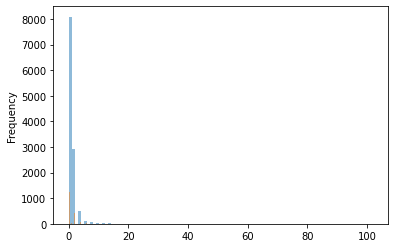

In [506]:
ax = data_train['num_crashes'].plot.hist(bins=100, alpha=0.5)
ax = data_test['num_crashes'].plot.hist(bins=100, alpha=0.5)

In [548]:
data_train = data_train.drop(['uid', 'Date', 'segment_id'], axis=1)
data_test = data_test.drop(['uid', 'Date', 'segment_id'], axis=1)
data_train = data_train.dropna()
data_test = data_test.dropna()

In [546]:
data_train['num_crashes'] = data_train['num_crashes'].apply(lambda x: x if x < 10 else 10)
data_test['num_crashes'] = data_test['num_crashes'].apply(lambda x: x if x < 10 else 10)

In [558]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

X_train, y_train = data_train.drop('num_crashes', axis=1), data_train['num_crashes']
X_test, y_test = data_test.drop('num_crashes', axis=1), data_test['num_crashes']

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
           
scaler.fit(X_test)
X_test = scaler.transform(X_test)

clf = LogisticRegression(class_weight='balanced').fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy score: ', accuracy_score(y_test, y_pred))

Accuracy score:  0.19224283305227655


/home/adalnhard/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [538]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[1231,    0],
       [ 548,    0]])

In [552]:
from sklearn.ensemble import RandomForestClassifier

X_train, y_train = data_train.drop('num_crashes', axis=1), data_train['num_crashes']
X_test, y_test = data_test.drop('num_crashes', axis=1), data_test['num_crashes']

clf = RandomForestClassifier(class_weight='balanced', random_state=42).fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy score: ', accuracy_score(y_test, y_pred))

Accuracy score:  0.9319842608206858


In [554]:
confusion_matrix(y_test, y_pred)

array([[1231,    0,    0,    0,    0,    0,    0,    0],
       [   0,   30,    0,    0,    0,    0,    0,    0],
       [  80,    0,  326,    0,    2,    0,    0,    0],
       [   0,    0,    0,    3,    0,    0,    0,    0],
       [  14,    0,    4,    0,   47,    0,    0,    0],
       [   5,    0,    1,    0,    0,    8,    0,    0],
       [   6,    0,    1,    0,    0,    0,    3,    1],
       [   5,    0,    2,    0,    0,    0,    0,   10]])

The score and confusion matrix are amazing. Let's make gridsearch and see if we can do even better.

In [ ]:
param_grid = {'n_estimators': [10, 20, 50, 100, 200],
              'max_depth': np.arange(2, 15)}
search = GridSearchCV(clf, param_grid, n_jobs=-1)
search.fit(X_train, y_train)

# Adding Uber Data

You can access speed data from https://movement.uber.com/explore/nairobi/speeds and clicking 'Download Data'. Here we'll load in the speeds from January 2019 and explore the data briefly.

In [12]:
speeds = pd.read_csv('Data/movement-speeds-hourly-nairobi-2019-1.csv', parse_dates=['utc_timestamp'])
speeds.head()

,year,month,day,hour,utc_timestamp,segment_id,start_junction_id,end_junction_id,osm_way_id,osm_start_node_id,osm_end_node_id,speed_kph_mean,speed_kph_stddev
0,2019,1,21,18,2019-01-21 15:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,20.025,5.147
1,2019,1,22,15,2019-01-22 12:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,20.572,11.282
2,2019,1,8,17,2019-01-08 14:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,17.325,3.055
3,2019,1,12,21,2019-01-12 18:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,19.284,2.032
4,2019,1,14,9,2019-01-14 06:00:00+00:00,41297ea07006246e330f9767862c5b85167eb37a,d97c55174d6c011dcd2bf3d1e05629b09dba739b,a996c01a24deb369c03c19b95b587a688ab2f9b8,8462710,3716534178,6287511790,19.827,3.316


In [ ]:
# Plot speeds over time for a specific OSM way
way = speeds.loc[speeds.osm_way_id == 133901081]
way = way.set_index('utc_timestamp')
way.resample('1h').mean().plot(y='speed_kph_mean')

In [ ]:
way.resample('1D').mean().plot(y='speed_kph_mean')

You can use any and all data available through Uber Movement, including linking the speeds data to OSM segments, downloading quarterly statistics, using the Movement Data Toolkit etc.

You can find much more info about working with the speeds data here: https://medium.com/uber-movement/working-with-uber-movement-speeds-data-cc01d35937b3 - including how to link the segment_id with OSM data

# What Next?

There are many ways you could approach this challenge. For example, you could:
- Create a model to predict the liklihood of an accident given a location, the features of the nearby road segments, the weather, the traffic speed and the time of day
- Use this model to predict the probability of crashes for different times+locations over the test period, and then sample from this probability distribution to generate plausible crash locations.
- Use an optimization technique to minimise the travel distance for the ambulances to your fake crash points. 

This might seem too complicated - perhaps simply picking 6 fixed locations based on the existing data will be enough? Or maybe it's worth setting separate locations during busy traffic times? 

Perhaps a Reinforcement Learning aproach will do well? 

Or maybe you can see a totally different way to solve this!

Share your ideas on the discussion boards, and let's see how innovative we can be :)